In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import egg.core as core

from typing import Any, List, Optional, Sequence, Union

import torch.utils.data
from torch_geometric.data import Batch, Dataset, Data
from torch_geometric.data.data import BaseData
from torch_geometric.data.datapipes import DatasetAdapter
from torch_geometric.data.on_disk_dataset import OnDiskDataset

In [10]:
from dataclasses import dataclass

@dataclass
class Options:
    # Agents
    embedding_size: int = 40 # Default: 50
    heads: int = 2 # Default: 1
    hidden_size: int = 20 # Default: 20
    sender_cell: str = 'gru' # 'rnn', 'gru', 'lstm'
    max_len: int = 4 # Default: 1
    gs_tau: int = 1.0 # Default: 1.0

    # Training
    n_epochs: int = 5
    vocab_size: int = 100 # Default: 100
    batch_size: int = 1 

opts = Options()

In [11]:
from graph.dataset import FamilyGraphDataset

dataset = FamilyGraphDataset(root='data', generations=2)
print(dataset[0].edge_attr)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [12]:
total_nodes = 0
for i in range(0, len(dataset)):
    total_nodes += dataset[i].x.shape[0]  # shape[0] gives the number of nodes in each graph

average_nodes = total_nodes / len(dataset)
print("Average number of nodes:", average_nodes)

Average number of nodes: 4.0


In [13]:
graph = dataset[0]
print(*graph, sep="\n")

('x', tensor([[ 0., 91.],
        [ 1., 95.],
        [ 0., 65.],
        [ 0., 70.]]))
('edge_index', tensor([[0, 2, 0, 3, 0, 1, 2, 1, 3, 1],
        [1, 0, 2, 0, 3, 0, 1, 2, 1, 3]]))
('edge_attr', tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]]))
('target_node_idx', 3)
('root_idx', 0)


In [4]:
graph.edge_attr

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]])

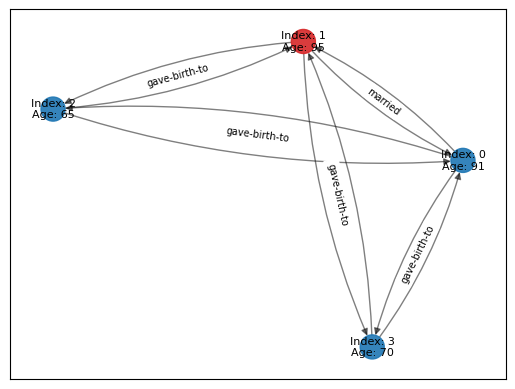

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(data):
    """
    Draw a directed graph based on the given data.

    Parameters:
    data (object): The data object containing the necessary information for drawing the graph.
    """

    # Create a new directed graph
    G = nx.DiGraph()

    # Add nodes with only age attributes (since names are not used)
    for i, attr in enumerate(data.x):
        G.add_node(i, age=int(attr[1]))

    # Add edges and edge labels based on the edge_index and edge_attr from PyG data
    edge_labels = {}
    for start, end, attr in zip(data.edge_index[0], data.edge_index[1], data.edge_attr):
        G.add_edge(start.item(), end.item())

        # Determine the relationship type based on the edge_attr tensor
        if attr.tolist() == [1, 0, 0]:
            relationship = 'married'
        elif attr.tolist() == [0, 1, 0]:
            relationship = 'child-of'
        elif attr.tolist() == [0, 0, 1]:
            relationship = 'gave-birth-to'
        else:
            relationship = 'unknown'

        edge_labels[(start.item(), end.item())] = relationship

    # Define node colors: 'blue' for male, 'red' for female
    node_colors = ['tab:blue' if gender == 0 else 'tab:red' for gender, _ in data.x.tolist()]

    # Position nodes using spring layout
    pos = nx.kamada_kawai_layout(G)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.9)

    # Draw the directed edges (arrows)
    nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.5, connectionstyle='arc3,rad=0.1')

    # Draw the edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    # Draw the node labels with index and age
    labels = {i: f"Index: {i}\nAge: {int(data.x[i, 1])}" for i in range(len(data.x))}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)  # Adjust font size as needed

    # Show the plot
    plt.show()

draw_graph(graph)

In [21]:
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, embedding_size, heads):
        super().__init__()
        # self.conv1 = GATv2Conv((embedding_size * heads), embedding_size, edge_dim=0, heads=heads, concat=True)
        self.conv1 = GATv2Conv(num_node_features, embedding_size, edge_dim=3, heads=heads, concat=True)
        self.conv2 = GATv2Conv(-1, embedding_size, edge_dim=3, heads=heads, concat=True)

    def forward(self, data):
        # _, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        h = F.dropout(h, training=self.training)

        h = self.conv2(x=h, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        return h
    
from torch_geometric.nn import TransformerConv

class Transform(torch.nn.Module):
    def __init__(self, num_node_features, embedding_size, heads):
        super().__init__()
        self.conv1 = TransformerConv(num_node_features, embedding_size, edge_dim=3, heads=heads, concat=True)
        self.conv2 = TransformerConv(-1, embedding_size, edge_dim=3, heads=heads, concat=True)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        h = F.dropout(h, training=self.training)

        h = self.conv2(x=h, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        return h

In [16]:
class SenderDual(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderDual, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h_t = self.transform(data)

       # h = self.gat(data, h_t)

        h_g = self.gat(data)

        h = h_t + h_g

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverDual(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverDual, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h_t = self.transform(data)

        # h = self.gat(data, h_t)

        h_g = self.gat(data)

        h = h_t + h_g   

        message_embedding = self.fc(message)        

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

In [22]:
class SenderGAT(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderGAT, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature

        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h = self.gat(data)

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverGAT(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverGAT, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size

        self.gat = GAT(self.num_node_features, embedding_size, heads)
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h = self.gat(data)   

        message_embedding = self.fc(message)                 

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

In [13]:
class SenderTransform(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderTransform, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature
          
        self.transform = Transform(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h = self.transform(data)

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverTransform(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverTransform, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        
        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h = self.transform(data)   

        message_embedding = self.fc(message)                 

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

In [14]:
class SenderRel(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderRel, self).__init__()
        self.num_node_features = 4
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads) * 2, hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx, root_idx = data.target_node_idx, data.root_idx

        h_t = self.transform(data)

        h_g = self.gat(data)

        h = h_t + h_g                       

        target = h[target_node_idx].squeeze()
        root = h[root_idx].squeeze()

        target_embedding = torch.cat((target, root))

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverRel(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverRel, self).__init__()
        self.num_node_features = 4
        self.heads = heads
        self.hidden_size = hidden_size

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h_t = self.transform(data)

        h_g = self.gat(data)

        h = h_t + h_g   

        message_embedding = self.fc(message)        

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

## Ouput for a single graph

In [18]:
agents = "gat"

In [23]:
if agents == "dual":
    sender = SenderDual(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverDual(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size)
elif agents == "transform":
    sender = SenderTransform(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverTransform(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size) 
elif agents == "gat":
    sender = SenderGAT(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverGAT(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size) 
elif agents == "rel":
    sender = SenderRel(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverRel(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size)
else:
    print("Invalid agent type")

In [24]:
print(dataset[0])

# Sender produces a message
sender_output = sender(None, dataset[0])
print("Sender's message:", sender_output)
print("Sender's shape: ", sender_output.shape)

# Receiver tries to identify the target node
receiver_output = receiver(sender_output, None, dataset[0])
print("Receiver's output:", receiver_output)
print("Receiver's shape: ", receiver_output.shape)

Data(x=[4, 2], edge_index=[2, 10], edge_attr=[10, 3], target_node_idx=3, root_idx=0)
Sender's message: tensor([[-4.5489,  5.2874, -2.2890,  0.2201,  5.0458,  2.1327,  7.6494, -0.9636,
          0.3771, -6.7636, -0.1882, -0.2243,  5.3831,  0.9653, -1.8407, -2.7949,
         -3.1433,  7.3107,  1.8298, -3.4687]], grad_fn=<ViewBackward0>)
Sender's shape:  torch.Size([1, 20])
Receiver's output: tensor([[-144.5400, -183.7269,    0.0000, -184.1559]],
       grad_fn=<LogSoftmaxBackward0>)
Receiver's shape:  torch.Size([1, 4])


In [71]:
sender_gs = core.RnnSenderGS(sender, opts.vocab_size, opts.embedding_size, opts.hidden_size, max_len=opts.max_len, temperature=opts.gs_tau, cell=opts.sender_cell)
receiver_gs = core.RnnReceiverGS(receiver, opts.vocab_size, opts.embedding_size, opts.hidden_size, cell=opts.sender_cell)

# Sender produces a message
sender_output = sender_gs(None, dataset[0])
#print("Sender's message:", sender_output)
print("Sender's shape:", sender_output.shape) # batch size x max_len+1 x vocab size

# Receiver tries to identify the target node
receiver_output = receiver_gs(sender_output, None, dataset[0])
#print("Receiver's output:", receiver_output)
print("Receiver's shape:", receiver_output.shape) # nodes x max_len+1 x num_classes (nodes)

Sender's shape: torch.Size([1, 5, 100])
Receiver's shape: torch.Size([1, 5, 4])


In [72]:
def loss_nll(
    _sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    NLL loss - differentiable and can be used with both GS and Reinforce
    """
    labels = torch.tensor([labels]).long()
    nll = F.nll_loss(receiver_output, labels, reduction="none")
    acc = (labels == receiver_output.argmax(dim=1)).float().mean()
    return nll, {"acc": acc}

game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

loss, interaction = game(sender_input=None, labels=graph.target_node_idx, receiver_input=None, aux_input=graph)
print(loss)
print("====================================")
#print(interaction)

tensor(100.1882, grad_fn=<MeanBackward0>)


## Batching

In [73]:
class Collater:
    def __init__(
        self,
        game_size: int,  # the number of graphs for a game
        dataset: Union[Dataset, Sequence[BaseData], DatasetAdapter],
        follow_batch: Optional[List[str]] = None,
        exclude_keys: Optional[List[str]] = None,
    ):
        self.game_size = game_size
        self.dataset = dataset
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys

    def __call__(self, batch: List[Any]) -> Any:
        elem = batch[0]
        if isinstance(elem, BaseData):
            batch = batch[:((len(batch) // self.game_size) * self.game_size)]  # we throw away the last batch_size % game_size
            batch = Batch.from_data_list(
                batch,
                follow_batch=self.follow_batch,
                exclude_keys=self.exclude_keys,
            )
            # we return a tuple (sender_input, labels, receiver_input, aux_input)
            # we use aux_input to store minibatch of graphs
            return (
                batch.x.view(1, -1), # sender_input
                batch.target_node_idx,  # the target is aways the first graph among game_size graphs
                None,  # we don't care about receiver_input
                batch  # this is a compact data for batch_size graphs 
            )

        raise TypeError(f"DataLoader found invalid type: '{type(elem)}'")

    def collate_fn(self, batch: List[Any]) -> Any:
        if isinstance(self.dataset, OnDiskDataset):
            return self(self.dataset.multi_get(batch))
        return self(batch)


class DataLoader(torch.utils.data.DataLoader):
    def __init__(
        self,
        game_size: int,  # the number of graphs for a game
        dataset: Union[Dataset, Sequence[BaseData], DatasetAdapter],
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: Optional[List[str]] = None,
        exclude_keys: Optional[List[str]] = None,
        **kwargs,
    ):
        self.game_size = game_size
        # Remove for PyTorch Lightning:
        kwargs.pop('collate_fn', None)

        # Save for PyTorch Lightning < 1.6:
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys

        self.collator = Collater(game_size, dataset, follow_batch, exclude_keys)

        if isinstance(dataset, OnDiskDataset):
            dataset = range(len(dataset))

        super().__init__(
            dataset,
            batch_size,
            shuffle,
            collate_fn=self.collator.collate_fn,
            **kwargs,
        )

In [74]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Print the lengths of the training and validation sets
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))

Training set length: 80
Validation set length: 20


In [77]:
train_loader = DataLoader(game_size=1, dataset=train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(game_size=1, dataset=val_data, batch_size=1, shuffle=True)

## Outputs for batch

In [78]:
batch = next(iter(train_loader))

In [79]:
print(batch[3])
print(batch[3].x)
print(batch[3].edge_index)
print(batch[3].edge_attr)
print(batch[0])

DataBatch(x=[4, 2], edge_index=[2, 10], edge_attr=[10, 3], target_node_idx=[1], root_idx=[1], batch=[4], ptr=[2])
tensor([[ 0., 99.],
        [ 1., 98.],
        [ 0., 77.],
        [ 0., 78.]])
tensor([[0, 2, 0, 3, 0, 1, 2, 1, 3, 1],
        [1, 0, 2, 0, 3, 0, 1, 2, 1, 3]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[ 0., 99.,  1., 98.,  0., 77.,  0., 78.]])


In [80]:
input = batch[0]
print(input.shape)

torch.Size([1, 8])


In [81]:
print(batch[3])

# Sender produces a message
sender_output = sender(None, batch[3])
#print("Sender's message:", sender_output)
print("Sender's shape: ", sender_output.shape)

# Receiver tries to identify the target node
receiver_output = receiver(sender_output, None, batch[3])
#print("Receiver's output:", receiver_output)
print("Receiver's shape: ", receiver_output.shape)

DataBatch(x=[4, 2], edge_index=[2, 10], edge_attr=[10, 3], target_node_idx=[1], root_idx=[1], batch=[4], ptr=[2])
Sender's shape:  torch.Size([1, 20])
Receiver's shape:  torch.Size([1, 4])


In [82]:
# Sender produces a message
sender_output = sender_gs(None, batch[3])
#print("Sender's message:", sender_output)
print("Sender's shape:", sender_output.shape) # batch size x max_len+1 x vocab size

# Receiver tries to identify the target node
receiver_output = receiver_gs(sender_output, None, batch[3])
#print("Receiver's output:", receiver_output)
print("Receiver's output shape:", receiver_output.shape)

Sender's shape: torch.Size([1, 5, 100])
Receiver's output shape: torch.Size([1, 5, 4])


In [83]:
def loss_nll(
    _sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    NLL loss - differentiable and can be used with both GS and Reinforce
    """
    nll = F.nll_loss(receiver_output, labels, reduction="none")
    acc = (labels == receiver_output.argmax(dim=1)).float().mean()
    return nll, {"acc": acc}

game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

loss, interaction = game(*batch)
print(loss)
print("====================================")
#print(interaction)

tensor(31.8570, grad_fn=<MeanBackward0>)


In [84]:
game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

options = core.init(params=['--random_seed=7', 
                         '--lr=1e-2',   
                         f'--batch_size={opts.batch_size}',
                         '--optimizer=adam',
                         '--update_freq=10'])

optimizer = torch.optim.Adam(game.parameters())

results = []

early_stopper = core.EarlyStopperAccuracy(0.63, validation=False)
message_entropy = core.MessageEntropy(print_train=True, is_gumbel=True)
topographic_similarity = core.TopographicSimilarity(
    sender_input_distance_fn="cosine", 
    message_distance_fn="euclidean", 
    compute_topsim_train_set=True, 
    compute_topsim_test_set=True, 
    is_gumbel=True
)
disent = core.Disent(
    is_gumbel=True, 
    compute_posdis=True, 
    compute_bosdis=False, 
    vocab_size=opts.vocab_size,
    print_test=True,
    print_train=True
)

trainer = core.Trainer(
    game=game, 
    optimizer=optimizer, 
    train_data=train_loader,
    validation_data=val_loader, 
    callbacks=[core.ConsoleLogger(as_json=True, print_train_loss=True)]
)

trainer.train(n_epochs=50)

{"loss": 1.9018245935440063, "acc": 0.31234902143478394, "length": 4.999574184417725, "mode": "train", "epoch": 1}
{"loss": 2.2249035835266113, "acc": 0.20000000298023224, "length": 5.0, "mode": "test", "epoch": 1}
{"loss": 2.0639381408691406, "acc": 0.18750007450580597, "length": 4.999999523162842, "mode": "train", "epoch": 2}
{"loss": 1.8713260889053345, "acc": 0.20000000298023224, "length": 5.0, "mode": "test", "epoch": 2}
{"loss": 1.2976906299591064, "acc": 0.30000001192092896, "length": 5.0, "mode": "train", "epoch": 3}
{"loss": 1.4213354587554932, "acc": 0.30000001192092896, "length": 5.0, "mode": "test", "epoch": 3}
{"loss": 1.2390903234481812, "acc": 0.21250000596046448, "length": 5.0, "mode": "train", "epoch": 4}
{"loss": 3.089514970779419, "acc": 0.30000001192092896, "length": 5.0, "mode": "test", "epoch": 4}
{"loss": 1.1034767627716064, "acc": 0.22499999403953552, "length": 5.0, "mode": "train", "epoch": 5}
{"loss": 3.440128803253174, "acc": 0.25, "length": 5.0, "mode": "tes

In [199]:
graph = dataset[1]
graph.target_node_idx = 3
print(graph)
print(graph.x)
print(graph.edge_index)
print(graph.edge_attr)

Data(x=[4, 2], edge_index=[2, 10], edge_attr=[10, 3], target_node_idx=3, root_idx=1)
tensor([[ 0., 87.],
        [ 1., 85.],
        [ 1., 64.],
        [ 0., 58.]])
tensor([[0, 2, 0, 3, 0, 1, 2, 1, 3, 1],
        [1, 0, 2, 0, 3, 0, 1, 2, 1, 3]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [154]:
def get_node_info(graph):
    node_info = {}

    # Define relationship types
    relationship_types = {tuple([1., 0., 0.]): 'married-to', tuple([0., 1., 0.]): 'child-of', tuple([0., 0., 1.]): 'gave-birth-to'}

    for index, features_tensor in enumerate(graph.x):
        # Node features
        features = features_tensor.tolist()
        gender = 'male' if features[0] == 0 else 'female'
        features_dict = {'gender': gender, 'features': features}

        # Relationships (considering only where the node is the source)
        relationships = []
        for i in range(graph.edge_index.shape[1]):
            if graph.edge_index[0, i] == index:  # Node is the source
                target_node = graph.edge_index[1, i]
                rel_type = relationship_types[tuple(graph.edge_attr[i].tolist())]
                relationships.append({'node': target_node.item(), 'relationship': rel_type})

        features_dict['relationships'] = relationships

        node_info[index] = features_dict

    return node_info

node_info = get_node_info(graph)
for node, info in node_info.items():
    print(f"Node {node}:", info)
print(node_info)

Node 0: {'gender': 'male', 'features': [0.0, 87.0], 'relationships': [{'node': 1, 'relationship': 'married-to'}, {'node': 2, 'relationship': 'gave-birth-to'}, {'node': 3, 'relationship': 'gave-birth-to'}]}
Node 1: {'gender': 'female', 'features': [1.0, 85.0], 'relationships': [{'node': 0, 'relationship': 'married-to'}, {'node': 2, 'relationship': 'gave-birth-to'}, {'node': 3, 'relationship': 'gave-birth-to'}]}
Node 2: {'gender': 'female', 'features': [1.0, 64.0], 'relationships': [{'node': 0, 'relationship': 'child-of'}, {'node': 1, 'relationship': 'child-of'}]}
Node 3: {'gender': 'male', 'features': [0.0, 58.0], 'relationships': [{'node': 0, 'relationship': 'child-of'}, {'node': 1, 'relationship': 'child-of'}]}
{0: {'gender': 'male', 'features': [0.0, 87.0], 'relationships': [{'node': 1, 'relationship': 'married-to'}, {'node': 2, 'relationship': 'gave-birth-to'}, {'node': 3, 'relationship': 'gave-birth-to'}]}, 1: {'gender': 'female', 'features': [1.0, 85.0], 'relationships': [{'node':

In [175]:
def sort_tree(node_data, start_node):
    visited = {start_node}

    def get_sorted_children(node_index):
        # Get direct relationships excluding already visited nodes
        relationships = [r for r in node_data[node_index]['relationships'] if r['node'] not in visited]
        
        # Check for 'married-to' relationship
        married_child = [child['node'] for child in relationships if child['relationship'] == 'married-to']
        
        # The rest of the children sorted by gender
        other_children = sorted([child['node'] for child in relationships if child['node'] not in married_child], 
                                key=lambda x: node_data[x]['gender'] == 'male')

        # Update visited nodes
        visited.update(married_child + other_children)
        return married_child + other_children

    def build_tree(node_index):
        children_indices = get_sorted_children(node_index)
        children = [build_tree(child_index) for child_index in children_indices]

        return {
            "index": node_index,
            "children": children
        }

    return build_tree(start_node)


tree = sort_tree(node_info, 3)
print(tree)

{'index': 3, 'children': [{'index': 1, 'children': [{'index': 2, 'children': []}]}, {'index': 0, 'children': []}]}


In [195]:
def build_sequence(tree, node_data, vocab):
    def node_sequence(node):
        # Add the gender of the current node
        sequence = [vocab[node_data[node['index']]['gender']]]
        
        for child in node['children']:
            # Add the relationship from the current node to the child
            relationship = next(r['relationship'] for r in node_data[node['index']]['relationships'] if r['node'] == child['index'])
            sequence.append(vocab[relationship])

            # Check if the child has its own children
            if child['children']:
                # If the child has children, use brackets
                sequence.append(vocab['('])  # Opening parenthesis
                sequence.extend(node_sequence(child))
                sequence.append(vocab[')'])  # Closing parenthesis
            else:
                # If the child has no children, just add the child's gender
                sequence.extend(node_sequence(child))

        return sequence

    # Convert the root of the tree
    sequence = node_sequence(tree)
    return torch.tensor([sequence], dtype=torch.float32)

vocab = {'(': 0, ')': 1, 'male': 2, 'female': 3, 'married-to': 4, 'child-of': 5, 'gave-birth-to': 6}
sequence = build_sequence(tree, node_info, vocab)
print(sequence)

tensor([[2., 5., 0., 3., 6., 3., 1., 5., 2.]])


In [200]:
def process_graph_to_sequence(graph):
    # Vocabulary
    vocab = {'(': 0, ')': 1, 'male': 2, 'female': 3, 'married-to': 4, 'child-of': 5, 'gave-birth-to': 6}

    # Function to get node information
    def get_node_info(graph):
        node_info = {}
        relationship_types = {tuple([1., 0., 0.]): 'married-to', tuple([0., 1., 0.]): 'child-of', tuple([0., 0., 1.]): 'gave-birth-to'}

        for index, features_tensor in enumerate(graph.x):
            features = features_tensor.tolist()
            gender = 'male' if features[0] == 0 else 'female'
            features_dict = {'gender': gender, 'features': features}

            relationships = []
            for i in range(graph.edge_index.shape[1]):
                if graph.edge_index[0, i] == index:
                    target_node = graph.edge_index[1, i]
                    rel_type = relationship_types[tuple(graph.edge_attr[i].tolist())]
                    relationships.append({'node': target_node.item(), 'relationship': rel_type})

            features_dict['relationships'] = relationships
            node_info[index] = features_dict

        return node_info

    # Function to sort tree
    def sort_tree(node_data, start_node):
        visited = {start_node}

        def get_sorted_children(node_index):
            relationships = [r for r in node_data[node_index]['relationships'] if r['node'] not in visited]
            married_child = [child['node'] for child in relationships if child['relationship'] == 'married-to']
            other_children = sorted([child['node'] for child in relationships if child['node'] not in married_child], 
                                    key=lambda x: node_data[x]['gender'] == 'male')
            visited.update(married_child + other_children)
            return married_child + other_children

        def build_tree(node_index):
            children_indices = get_sorted_children(node_index)
            children = [build_tree(child_index) for child_index in children_indices]
            return {"index": node_index, "children": children}

        return build_tree(start_node)

    # Function to build sequence
    def build_sequence(tree, node_data, vocab):
        def node_sequence(node):
            sequence = [vocab[node_data[node['index']]['gender']]]
            for child in node['children']:
                relationship = next(r['relationship'] for r in node_data[node['index']]['relationships'] if r['node'] == child['index'])
                sequence.append(vocab[relationship])

                if child['children']:
                    sequence.append(vocab['('])  # Opening parenthesis
                    sequence.extend(node_sequence(child))
                    sequence.append(vocab[')'])  # Closing parenthesis
                else:
                    sequence.extend(node_sequence(child))

            return sequence

        sequence = node_sequence(tree)
        return torch.tensor([sequence], dtype=torch.float32)

    # Process graph to sequence
    node_info = get_node_info(graph)
    tree = sort_tree(node_info, graph.target_node_idx)
    sequence_tensor = build_sequence(tree, node_info, vocab)

    return sequence_tensor

# Example usage (assuming graph and graph.target_node_idx are defined)
sequence_tensor = process_graph_to_sequence(graph)
print(sequence_tensor)


tensor([[2., 5., 0., 3., 6., 3., 1., 5., 2.]])
